## Question 1

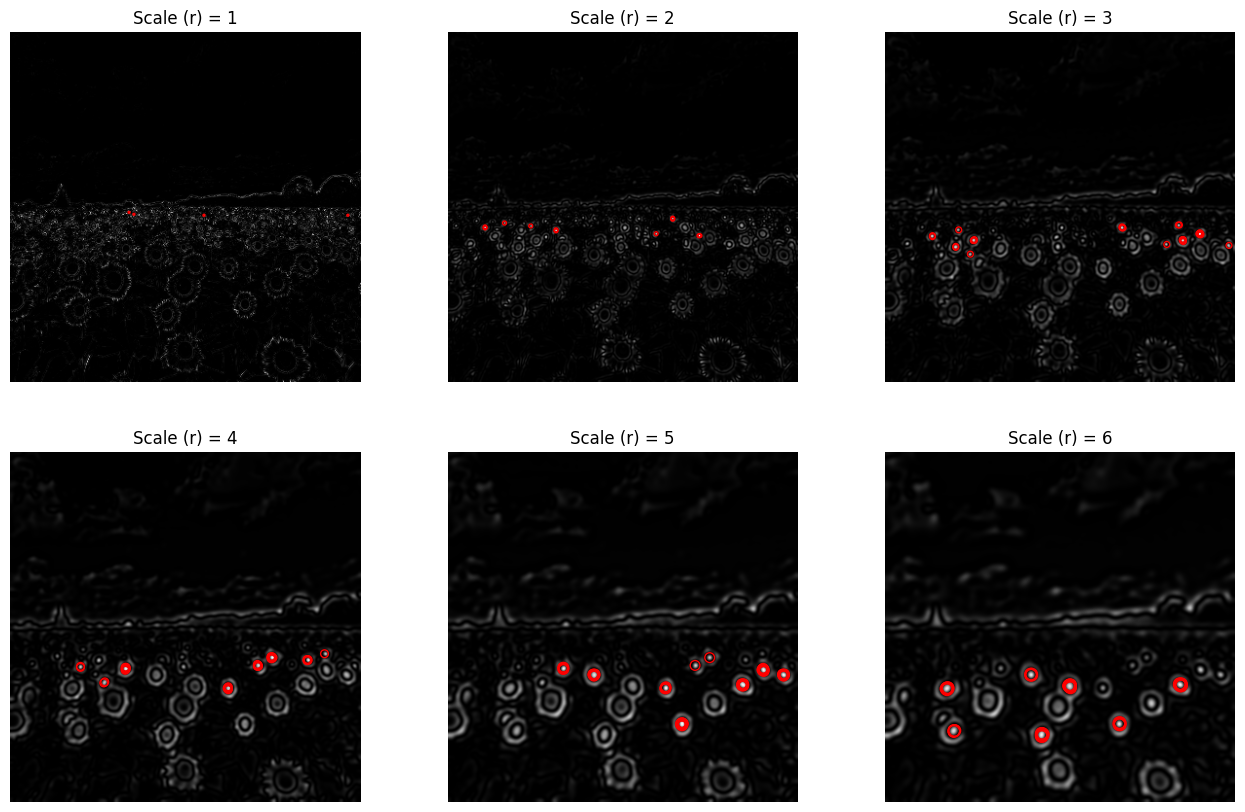

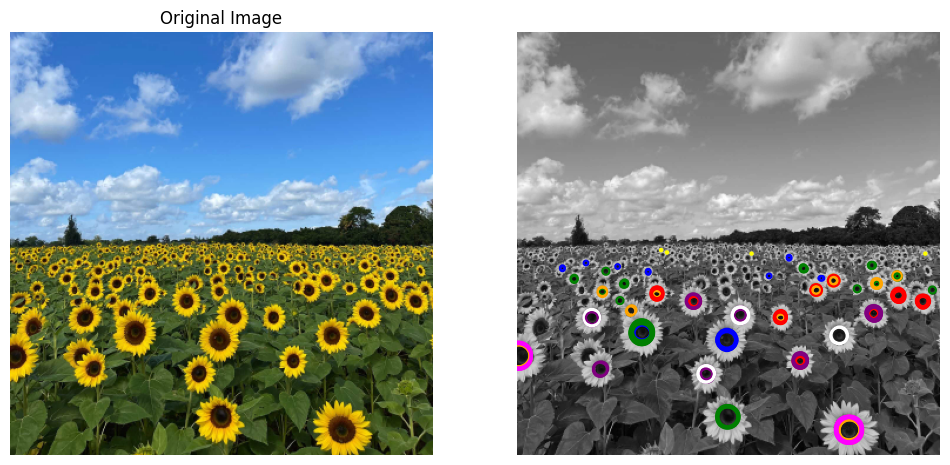

In [12]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def generate_log_kernel(sigma):
    """Generate Laplacian of Gaussian (LoG) kernel."""
    radius = int(3 * sigma)
    x, y = np.meshgrid(np.arange(-radius, radius + 1), np.arange(-radius, radius + 1))
    kernel = ((x**2 + y**2) / (2 * sigma**2) - 1) * np.exp(-(x**2 + y**2) / (2 * sigma**2)) / (np.pi * sigma**4)
    return kernel

def find_blob_centers(log_image, sigma):
    """Find local maxima in the LoG response image."""
    coords = []
    height, width = log_image.shape
    neighborhood = 1  # 3x3 window size
    for row in range(neighborhood, height-neighborhood):
        for col in range(neighborhood, width-neighborhood):
            local_window = log_image[row-neighborhood:row+neighborhood+1, col-neighborhood:col+neighborhood+1]
            max_response = np.max(local_window)
            if max_response >= 0.10:  # Adjust threshold for detection
                x_offset, y_offset = np.unravel_index(np.argmax(local_window), local_window.shape)
                coords.append((row + x_offset - neighborhood, col + y_offset - neighborhood))
    return set(coords)

# Load the image
img_path = 'the_berry_farms_sunflower_field.jpeg'
image = cv.imread(img_path, cv.IMREAD_REDUCED_COLOR_4)
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) / 255.0

# Create a grid of subplots to display the LoG filtered images
fig, axis_grid = plt.subplots(2, 3, figsize=(16, 10))


for idx, (r, ax) in enumerate(zip(range(1, 12), axis_grid.flatten())):
    sigma = r / 1.414  # Maintain the same sigma scaling
    log_kernel = sigma ** 2 * generate_log_kernel(sigma)
    
    # Apply Laplacian of Gaussian filter to the grayscale image
    log_response = np.square(cv.filter2D(gray_image, -1, log_kernel))
    
    # Detect blob centers based on the LoG response
    blob_centers = find_blob_centers(log_response, sigma)

    # Display the LoG filtered image
    ax.imshow(log_response, cmap='gray')
    ax.set_title(f'Scale (r) = {r}', fontsize=12)

    # Draw circles around detected blobs
    for x, y in blob_centers:
        circle = plt.Circle((y, x), sigma * 1.414, color='red', linewidth=1, fill=False)
        ax.add_patch(circle)

    ax.axis('off')

plt.show()

# Display the original image with detected blobs overlayed
fig, (ax_original, ax_overlay) = plt.subplots(1, 2, figsize=(12, 12))

# Show the original image
ax_original.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
ax_original.set_title("Original Image")
ax_original.axis('off')

# Show the grayscale image with detected blobs overlayed
ax_overlay.imshow(gray_image, cmap='gray')
# ax_overlay.set_title("Detected Blobs with Different Scales (2, 4, 6, 8, 10, 12)")
ax_overlay.axis('off')

# List of colors for different blob scales
color_palette = ['yellow', 'blue', 'green', 'orange', 'red', 'purple','white', 'blue', 'green', 'orange', 'magenta', 'purple']

# Loop through the same sigma values: r = 2, 4, 6, 8, 10, 12
for i, r in enumerate(range(1, 12)):
    sigma = r / 1.414
    log_kernel = sigma ** 2 * generate_log_kernel(sigma)
    
    # Apply LoG filter and find blobs
    log_response = np.square(cv.filter2D(gray_image, -1, log_kernel))
    blob_centers = find_blob_centers(log_response, sigma)

    # Draw blobs as circles with different colors based on the scale
    for x, y in blob_centers:
        circle = plt.Circle((y, x), sigma * 1.414, color=color_palette[i], linewidth=1.5, fill=False)
        ax_overlay.add_patch(circle)

# Show the final plot
plt.show()

## Question 2

<Axes: >

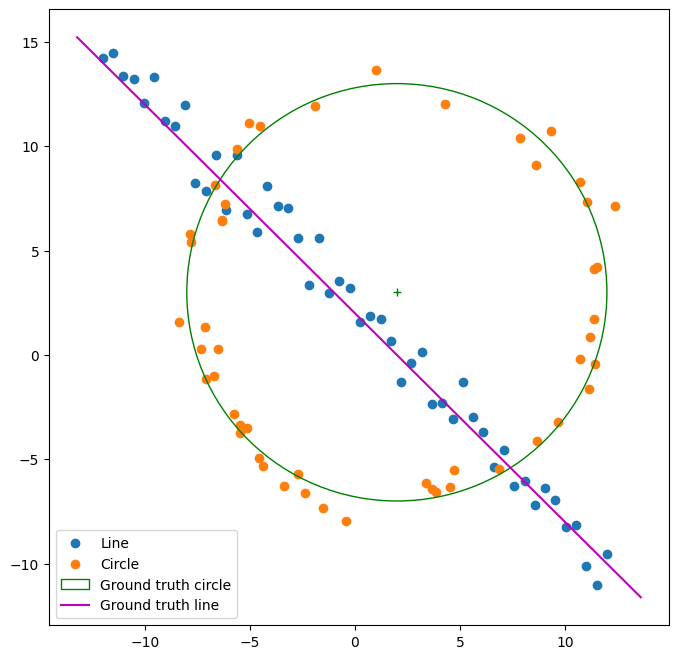

In [17]:
# Generating noisy point set

from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np
#import tikzplotlib

# Set random seed
np.random.seed(0)

# Constants
N = 100
half_n = N // 2

# Parameters
r = 10
x0_gt, y0_gt = 2, 3
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s, m, b = 1, -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))

# Plotting
def plot_all(separate = True):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    if separate:
        ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
        ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
    else:
        ax.scatter(X[:, 0], X[:, 1], label='Point Set')

    circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
    ax.add_patch(circle_gt)
    ax.plot(x0_gt, y0_gt, '+', color='g')

    x_min, x_max = ax.get_xlim()
    x_ = np.array([x_min, x_max])
    y_ = m * x_ + b
    plt.plot(x_, y_, color='m', label='Ground truth line')

    plt.legend()
    return ax

plot_all()

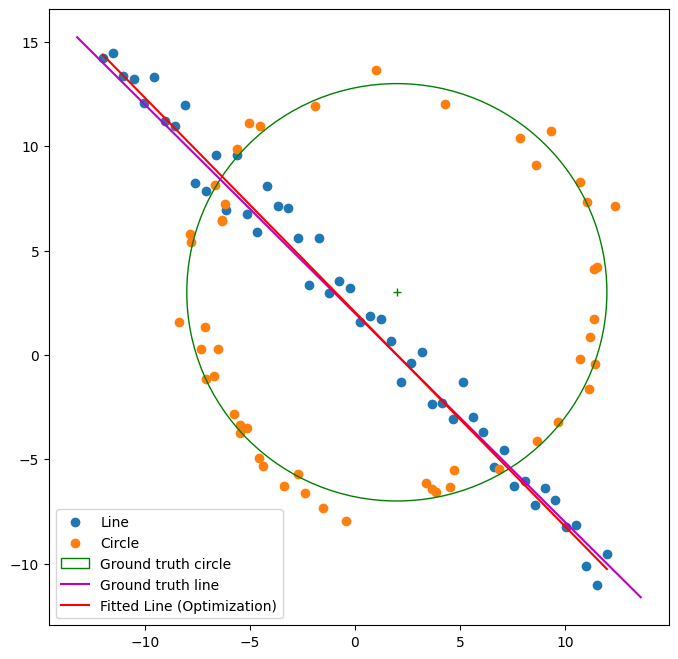

Optimized line parameters: a = -0.716, b = -0.698, d = 1.438


In [21]:
from scipy.optimize import minimize

# Cost function for line fitting: sum of distances from points to the line
def line_cost(params, X):
    a, b, d = params  # Line parameters
    distances = np.abs(a * X[:, 0] + b * X[:, 1] + d)
    return np.sum(distances)

# Constraint: a^2 + b^2 = 1 (unit normal vector)
def unit_normal_constraint(params):
    a, b, d = params
    return (a**2 + b**2)**0.5 - 1

# Initial guess for the line parameters
initial_params = [1, -1, 0]

# Set up constraints for optimization
constraints = {'type': 'eq', 'fun': unit_normal_constraint}

# Perform optimization to fit the line
result = minimize(line_cost, initial_params, args=(X,), constraints=constraints)

# Extract the best-fit line parameters
a_opt, b_opt, d_opt = result.x

# Plotting the fitted line and noisy points
ax = plot_all()

# Plot the fitted line
x_vals = np.linspace(-12, 12, 100)
y_vals = -(a_opt * x_vals + d_opt) / b_opt
plt.plot(x_vals, y_vals, color='r', label='Fitted Line (Optimization)')

plt.legend()
plt.show()

# Output the optimized parameters
print(f"Optimized line parameters: a = {a_opt:.3f}, b = {b_opt:.3f}, d = {d_opt:.3f}")


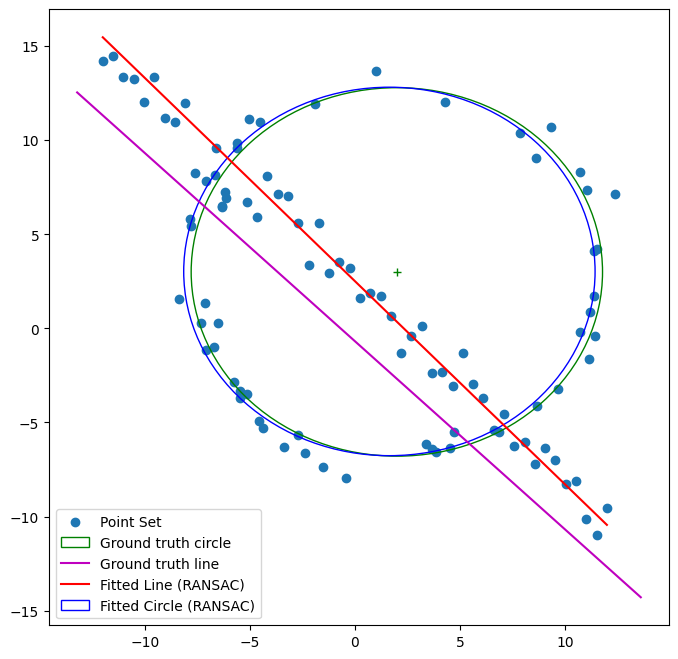

Line parameters: a = -0.734, b = -0.679, d = 1.708
Circle parameters: x0 = 1.645, y0 = 3.025, r = 9.792


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from random import sample

# Helper function to calculate the distance of points to a line ax + by + d = 0
def line_distance(points, a, b, d):
    return np.abs(a * points[:, 0] + b * points[:, 1] + d) / np.sqrt(a**2 + b**2)
    # return np.abs((points[:, 0]**2 + points[:, 1]**2)**0.5)

# Helper function to fit a line through two points
def fit_line(p1, p2):
    a = p1[1] - p2[1]  # y1 - y2
    b = p2[0] - p1[0]  # x2 - x1
    d = -(a * p1[0] + b * p1[1])  # ax1 + by1 + d = 0
    norm = np.sqrt(a**2 + b**2)
    return a / norm, b / norm, d / norm

# RANSAC for line fitting
def ransac_line(points, threshold, num_iterations=100):
    best_a, best_b, best_d = None, None, None
    best_consensus = []

    for _ in range(num_iterations):
        # Randomly select 2 points
        p1, p2 = points[sample(range(len(points)), 2)]
        # print(points)
        
        # Fit a line through them
        a, b, d = fit_line(p1, p2)
        
        # Compute the consensus set (points that are close to the line)
        distances = line_distance(points, a, b, d)
        consensus_set = points[distances < threshold]
        
        # Update the best line if this one has more inliers
        if len(consensus_set) > len(best_consensus):
            best_a, best_b, best_d = a, b, d
            best_consensus = consensus_set

    return best_a, best_b, best_d, best_consensus

# Helper function to calculate the radial distance of points to a circle
def circle_distance(points, x0, y0, r):
    return np.abs(np.sqrt((points[:, 0] - x0)**2 + (points[:, 1] - y0)**2) - r)

# Helper function to fit a circle through 3 points
def fit_circle(p1, p2, p3):
    A = np.array([[p1[0], p1[1], 1],
                  [p2[0], p2[1], 1],
                  [p3[0], p3[1], 1]])
    B = np.array([-(p1[0]**2 + p1[1]**2),
                  -(p2[0]**2 + p2[1]**2),
                  -(p3[0]**2 + p3[1]**2)])
    sol = np.linalg.solve(A, B)
    x0, y0 = -0.5 * sol[0], -0.5 * sol[1]
    r = np.sqrt((sol[0]**2 + sol[1]**2) / 4 - sol[2])
    return x0, y0, r

# RANSAC for circle fitting
def ransac_circle(points, threshold, num_iterations=100):
    best_x0, best_y0, best_r = None, None, None
    best_consensus = []

    for _ in range(num_iterations):
        # Randomly select 3 points
        p1, p2, p3 = points[sample(range(len(points)), 3)]
        
        # Fit a circle through them
        try:
            x0, y0, r = fit_circle(p1, p2, p3)
        except np.linalg.LinAlgError:
            continue  

        # Compute the consensus set (points that are close to the circle)
        distances = circle_distance(points, x0, y0, r)
        consensus_set = points[distances < threshold]

        # Update the best circle if this one has more inliers
        if len(consensus_set) > len(best_consensus):
            best_x0, best_y0, best_r = x0, y0, r
            best_consensus = consensus_set

    return best_x0, best_y0, best_r, best_consensus

# Apply RANSAC to the noisy data
threshold_line = 0.5
threshold_circle = 0.5

# First, fit a line and remove inliers
a, b, d, line_consensus = ransac_line(X, threshold_line)
X_remnant = np.array([point for point in X if point not in line_consensus])

# Then, fit a circle to the remaining points
x0, y0, r, circle_consensus = ransac_circle(X_remnant, threshold_circle)

# Plotting results
ax = plot_all(separate=False)
# Plot the fitted line
x_vals = np.linspace(-12, 12, 100)
y_vals = -(a * x_vals + d) / b
plt.plot(x_vals, y_vals, color='r', label='Fitted Line (RANSAC)')

# Plot the fitted circle
fitted_circle = plt.Circle((x0, y0), r, color='b', fill=False, label='Fitted Circle (RANSAC)')
ax.add_patch(fitted_circle)

plt.legend()
plt.show()

# Print results
print(f"Line parameters: a = {a:.3f}, b = {b:.3f}, d = {d:.3f}")
print(f"Circle parameters: x0 = {x0:.3f}, y0 = {y0:.3f}, r = {r:.3f}")


## Question 3

In [3]:
import numpy as np
import cv2 as cv
from skimage import transform

# Load the images
im1 = cv.imread('005.jpg')
im2 = cv.imread('flag.png')
assert im1 is not None and im2 is not None, "Error loading images"

# Number of points to select
N = 4
selected_points = np.empty((N, 2), dtype=np.float32)
current_point = 0

# Callback function to handle mouse events
def select_points(event, x, y, flags, param):
    global current_point
    if event == cv.EVENT_LBUTTONDOWN and current_point < N:
        cv.circle(param, (x, y), 5, (0, 255, 0), -1)
        selected_points[current_point] = (x, y)
        current_point += 1

# Make a copy of the image to draw on
im1_copy = im1.copy()

# Set up the window and callback
cv.namedWindow('Image 1', cv.WINDOW_AUTOSIZE)
cv.setMouseCallback('Image 1', select_points, im1_copy)

# Event loop to display the image and capture points
while current_point < N:
    cv.imshow('Image 1', im1_copy)
    if cv.waitKey(20) & 0xFF == 27:  # Exit on 'Esc' key
        break

cv.destroyAllWindows()

# Print the selected points
dst_points = selected_points
print("Selected points:", dst_points)

Selected points: [[422. 345.]
 [318. 295.]
 [309. 432.]
 [419. 459.]]


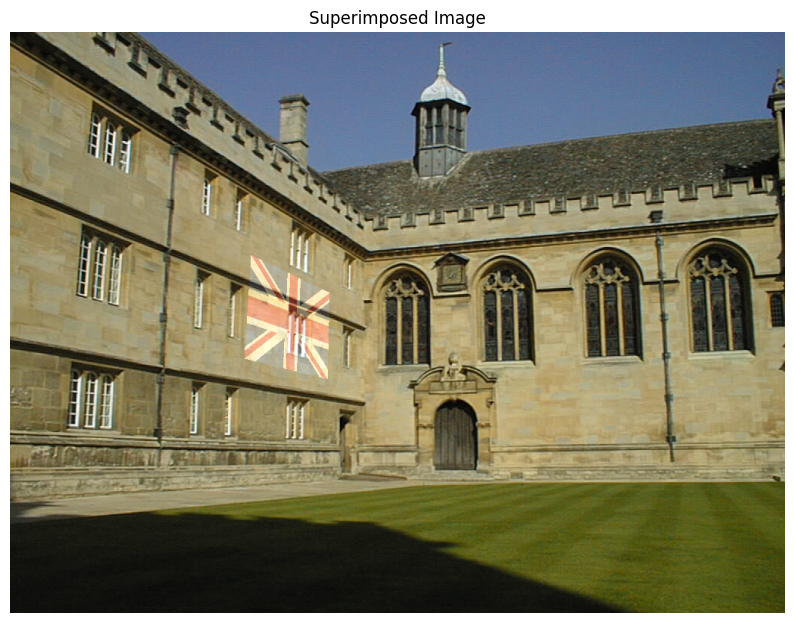

True

In [5]:
import cv2 as cv
import numpy as np
from skimage import transform
import matplotlib.pyplot as plt

def superimpose(image, logo, dst_points, beta=0.3, alpha=1):
    # Resize the logo to fit within the destination points
    h, w, _ = logo.shape
    src_points = np.array([(0, 0), (w, 0), (w, h), (0, h)], dtype=np.float32)  # tl, tr, br, bl
    
    # Estimate projective transformation from src_points to dst_points
    tform = transform.estimate_transform('projective', src_points, dst_points)

    # Warp the logo image according to the transformation matrix
    tf_img = transform.warp(logo, tform.inverse, output_shape=image.shape[:2])  # Preserve original image size
    tf_img = (tf_img * 255).astype(np.uint8)

    # Create mask for non-zero pixels in the warped logo image
    mask = np.any(tf_img > 0, axis=-1).astype(np.uint8)  # Binary mask of logo area
    
    # Blend the images using cv2.addWeighted
    blended = cv.addWeighted(image, alpha, tf_img, beta, 0)

    # Combine the result only where the logo was applied
    result = np.where(mask[:, :, np.newaxis], blended, image)
    
    return result

# need to superimpose the immage flag into the 005 image in the dst_points
image = cv.imread('005.jpg')  # Base image
logo = cv.imread('flag.png')  # Logo image (flag)

# Convert BGR to RGB for displaying with Matplotlib (optional)
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
logo_rgb = cv.cvtColor(logo, cv.COLOR_BGR2RGB)

# Superimpose the logo on the image
result = superimpose(image_rgb, logo_rgb, dst_points)

# Plotting the result
plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.axis('off')  # Turn off axis labels
plt.title('Superimposed Image')
plt.show()

# Optionally, save the output image
cv.imwrite('superimposed_image.jpg', cv.cvtColor(result, cv.COLOR_RGB2BGR))  # Save as BGR format for OpenCV

